now only fish/engine

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Paths
data_folder = "./time_sets_standardized"

# Load Data
def load_csv_data(folder_path):
    data, labels = [], []
    status_counts = {}
    valid_files = 0
    skipped_files = 0  # New counter to track skipped files

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))

            if "Heading" not in df.columns or df["Heading"].isnull().any():
                skipped_files += 1  # Increment skipped files
                continue

            features = df[["SOG", "COG", "Heading"]].values
            label = df["Navigational status"].iloc[0]

            if label in ["Under way using engine", "Engaged in fishing"]:
                data.append(features)
                labels.append(label)

                if label not in status_counts:
                    status_counts[label] = 0
                status_counts[label] += 1

                valid_files += 1

    print(f"Skipped {skipped_files} files due to missing 'Heading' values or other issues.")
    return np.array(data), np.array(labels), status_counts, valid_files

# Preprocess Data
def preprocess_data(data, labels):
    # Initialize scalers for each feature
    sog_scaler = StandardScaler()
    cog_scaler = StandardScaler()
    heading_scaler = StandardScaler()

    processed_data = []
    for vessel_data in data:
        # Standardize each feature independently across all vessels
        sog = vessel_data[:, 0].reshape(-1, 1)
        cog = vessel_data[:, 1].reshape(-1, 1)
        heading = vessel_data[:, 2].reshape(-1, 1)

        # Apply standardization
        sog = sog_scaler.fit_transform(sog)
        cog = cog_scaler.fit_transform(cog)
        heading = heading_scaler.fit_transform(heading)

        # Calculate rate of change for SOG and COG
        sog_rate_of_change = np.diff(sog, axis=0)
        cog_rate_of_change = np.diff(cog, axis=0)

        # Pad the first time step with zeros for rate of change
        sog_rate_of_change = np.pad(sog_rate_of_change, ((1, 0), (0, 0)), mode='constant')
        cog_rate_of_change = np.pad(cog_rate_of_change, ((1, 0), (0, 0)), mode='constant')

        # Calculate cumulative sum of SOG over time
        sog_cumulative_sum = np.cumsum(sog, axis=0)

        # Add new features to the vessel data
        new_features = np.hstack([sog, cog, heading, sog_rate_of_change, cog_rate_of_change, sog_cumulative_sum])

        processed_data.append(new_features)

    data = np.array(processed_data)
    
    # Encode labels (transform categorical labels to numeric)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    return data, labels, label_encoder

# Function to apply undersampling
# Function to apply undersampling with debugging
def undersample_data(X, y):
    # Check class distribution before undersampling
    print("Before undersampling:")
    unique, counts = np.unique(y, return_counts=True)
    print(f"Class distribution: {dict(zip(unique, counts))}")
    
    # Separate the data by class
    class_0 = X[y == 0]  # Minority class (assuming 0 is the minority)
    class_1 = X[y == 1]  # Majority class (assuming 1 is the majority)
    
    # Check sizes of each class
    print(f"Class 0 size: {len(class_0)}")
    print(f"Class 1 size: {len(class_1)}")

    # Perform undersampling on the majority class
    class_1_undersampled = resample(class_1, 
                                    replace=False,     # Do not replace, reduce size
                                    n_samples=len(class_0),  # Match number of samples in minority class
                                    random_state=42)   # Fix random seed for reproducibility

    # Combine the undersampled majority class with the minority class
    X_balanced = np.vstack((class_0, class_1_undersampled))
    y_balanced = np.hstack((np.zeros(len(class_0)), np.ones(len(class_1_undersampled))))

    # Check class distribution after undersampling
    print("After undersampling:")
    unique, counts = np.unique(y_balanced, return_counts=True)
    print(f"Class distribution: {dict(zip(unique, counts))}")
    
    # Check the shape of the balanced dataset
    print(f"Balanced X shape: {X_balanced.shape}")
    print(f"Balanced y shape: {y_balanced.shape}")
    
    return X_balanced, y_balanced
# Load and preprocess data
data, labels, status_counts, valid_files = load_csv_data(data_folder)

# Check status counts after filtering for the two categories
print(f"Number of valid files: {valid_files}")
print("Files per Navigational Status:")
for status, count in status_counts.items():
    print(f"{status}: {count} files")

# Preprocess the data
data, labels, label_encoder = preprocess_data(data, labels)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Apply undersampling to the training data
X_train_balanced, y_train_balanced = undersample_data(X_train, y_train)

# Define the Bidirectional LSTM Model
n_timesteps, n_features = data.shape[1], data.shape[2]
n_classes = 2  # We now have only two classes

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')  # Output layer with 2 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model without class_weights (as we've balanced the dataset)
model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


2024-12-26 12:38:03.764677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 12:38:03.766072: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 12:38:03.769135: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 12:38:03.777913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735216683.792623   31905 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735216683.79

Skipped 0 files due to missing 'Heading' values or other issues.
Number of valid files: 12373
Files per Navigational Status:
Under way using engine: 7944 files
Engaged in fishing: 4429 files
Before undersampling:
Class distribution: {np.int64(0): np.int64(3517), np.int64(1): np.int64(6381)}
Class 0 size: 3517
Class 1 size: 6381
After undersampling:
Class distribution: {np.float64(0.0): np.int64(3517), np.float64(1.0): np.int64(3517)}
Balanced X shape: (7034, 90, 6)
Balanced y shape: (7034,)
Epoch 1/20


2024-12-26 12:38:34.224591: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.5037 - loss: 0.7038 - val_accuracy: 0.5733 - val_loss: 0.6828
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.5543 - loss: 0.6886 - val_accuracy: 0.4667 - val_loss: 0.7366
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.5427 - loss: 0.6899 - val_accuracy: 0.5947 - val_loss: 0.6761
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 43s 158ms/step - accuracy: 0.5676 - loss: 0.6802 - val_accuracy: 0.5774 - val_loss: 0.6848
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.5677 - loss: 0.6811 - val_accuracy: 0.5467 - val_loss: 0.6949
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.5773 - loss: 0.6735 - val_accuracy: 0.5552 - val_loss: 0.6926
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.5858 - loss: 0.6696 - val_accuracy: 0.5531 - val_loss: 0.6902
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 45s 165ms/step - accuracy: 0.5957 - loss: 0.6659 - val

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
Classification Report:
                        precision    recall  f1-score   support

    Engaged in fishing       0.43      0.58      0.49       912
Under way using engine       0.69      0.54      0.61      1563

              accuracy                           0.56      2475
             macro avg       0.56      0.56      0.55      2475
          weighted avg       0.59      0.56      0.57      2475



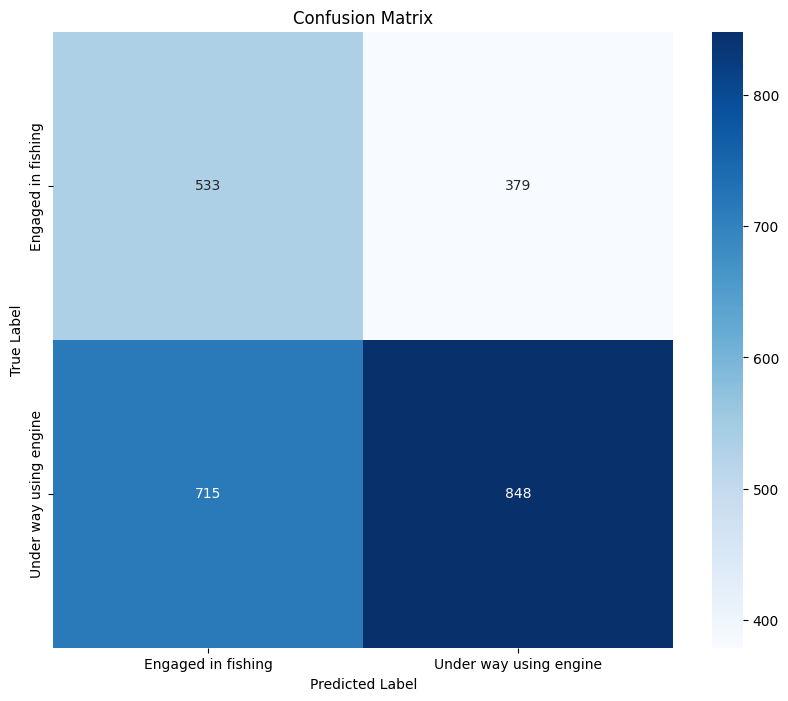

Accuracy: 0.56
Precision: 0.59
Recall: 0.56
F1 Score: 0.57


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average="weighted")
recall = recall_score(y_test, y_pred_classes, average="weighted")
f1 = f1_score(y_test, y_pred_classes, average="weighted")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
